# Graph Neural Network Modelling

---

## Download and Importing Essential Packages

In [ ]:
%%capture
import torch
version = torch.__version__
i = version.find('+')
version = version[:i-1] + '0' + version[i:]
url = 'https://data.pyg.org/whl/torch-' + version + '.html'

!pip install torch-scatter -f $url
!pip install torch-sparse -f $url
!pip install torch-geometric
!pip install torch-cluster -f $url
!pip install pygod
!pip install --upgrade scipy

In [ ]:
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv

import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
from collections import Counter

from sklearn.metrics import classification_report

In [ ]:
def make_deterministic(random_seed = 123):
    """
    Configure the random number generators in PyTorch and NumPy for deterministic behavior.
    This ensures reproducibility of results in experiments by fixing the seed for random number generation
    across CPU and GPU operations in PyTorch, and also in NumPy. It also disables non-deterministic
    algorithms in PyTorch's cuDNN backend to ensure consistency across multiple runs.
    """
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

make_deterministic()

## 1.0 Loading Data

This notebook focuses on implementing various Graph Neural Networks (GNNs) using PyTorch Geometric (PyG). We will leverage the [Cora dataset](https://paperswithcode.com/dataset/cora), a well-known citation network containing 2,708 scientific publications. In this network, each publication is represented as a node, and edges connect publications if one cites the other. By employing [PyG](https://www.pyg.org/), we can conveniently load the Cora dataset and proceed with the model implementation.

In [ ]:
%%capture
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora') # store the dataset at the local directory

In [ ]:
def show_dataset_stats(dataset):
    print(f"Number of graphs: {len(dataset)}")
    print(f"Number of node classes: {dataset.num_classes}")
    print(f"Number of node features: {dataset.num_node_features}")

show_dataset_stats(dataset) # display the dimension of dataset

Number of graphs: 1
Number of node classes: 7
Number of node features: 1433


In [ ]:
def show_graph_stats(graph):
    print(f"Number of nodes: {graph.x.shape[0]}")
    print(f"Number of node features: {graph.x.shape[1]}")
    print(f"Number of edges: {graph.edge_index.shape[1]}")

graph = dataset[0]
show_graph_stats(graph) # display the dimension of graph

Number of nodes: 2708
Number of node features: 1433
Number of edges: 10556


In [ ]:
# Check the information
print(f'Has isolated nodes: {graph.has_isolated_nodes()}')  # False
print(f'Has self-loops: {graph.has_self_loops()}')  # False
print(f'Is undirected: {graph.is_undirected()}')  # True

Has isolated nodes: False
Has self-loops: False
Is undirected: True


<font color='orange'>Important Notes:</font>
The first line of code confirms that there are no nodes not connected by edges, the second line of code shows that there are no self-loops. However, the number of edges seems to be `10556`. This is due to the `bi-directional edge information` included which shown in the third line.

The node features and the edge information look like below. The node features are 1433 word vectors indicating the absence (0) or the presence (1) of the words in each publication. The edges are represented in adjacency lists.

In [ ]:
graph.x # node features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
graph.edge_index.T # edge information

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

Class label information: [Keras GNN](https://keras.io/examples/graph/gnn_citations/)

In [ ]:
# Maps numeric labels to corresponding machine learning topics in the Cora dataset.
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

In [ ]:
# Retrieve the value count for each class in the dataset
counter = Counter(graph.y.numpy())
counter = dict(sorted(counter.items(), key=lambda item: item[0]))
print(counter)

{0: 351, 1: 217, 2: 418, 3: 818, 4: 426, 5: 298, 6: 180}


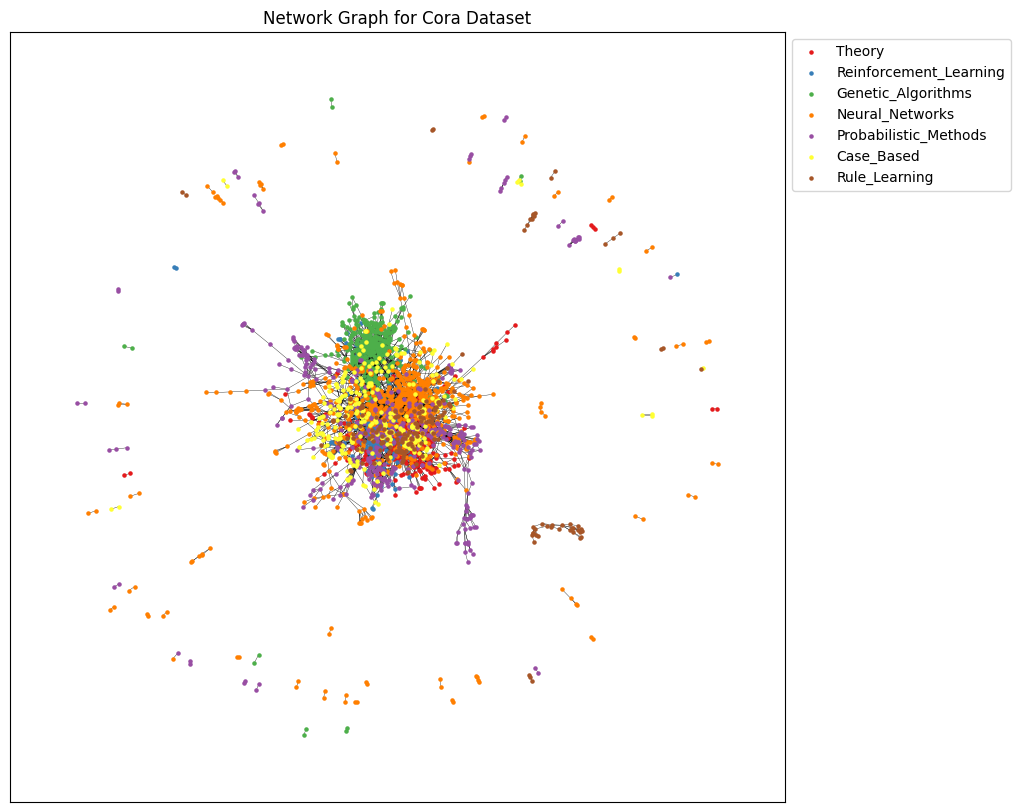

In [ ]:
# Convert data to a NetworkX graph
G = to_networkx(graph, to_undirected=True)

# Initialize node color list and node lists for different classes
node_color = []
nodelist = [[] for _ in range(7)]  # Create 7 empty lists for the 7 classes
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00', '#984ea3', '#ffff33', '#a65628']

labels = graph.y

# Assign colors and group nodes by their labels
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)

# Compute the layout for the graph
pos = nx.spring_layout(G, seed=42)

# Create the figure for the plot
plt.figure(figsize=(10, 10))

# Draw nodes for each class with different colors and labels
labellist = list(label_dict.values())
for num, (nodes, label) in enumerate(zip(nodelist, labellist)):
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=5, node_color=colorlist[num], label=label)

# Draw the edges of the graph
nx.draw_networkx_edges(G, pos, width=0.25)

# Add a title and legend to the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title("Network Graph for Cora Dataset")

# Display the plot
plt.show()

## 2.0 Node Classification
For the node classification problem, we are splitting the nodes into train, valid, and test using the `RandomNodeSplit` module from PyG (we are replacing the original split masks in the data as it has a too small train set).

<font color='orange'>Original train_test_val mask:</font>
```
# Check the train test split
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Number of validation nodes: {data.val_mask.sum()}")
print(f"Number of testing nodes: {data.test_mask.sum()}")
```
* `Training`: {3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20} = 140
* `Validation`: {4: 81, 3: 158, 0: 61, 6: 29, 1: 36, 2: 78, 5: 57} = 500
* `Test`: {3: 319, 2: 144, 0: 130, 1: 91, 5: 103, 4: 149, 6: 64} = 1000

In [ ]:
split = T.RandomNodeSplit(num_val=0.1, num_test=0.1) # split the data into train, val, and test
graph = split(graph)  # resetting data split
print(
    f"Training: {int(graph.train_mask.sum())}, ",
    f"Testing: {int(graph.test_mask.sum())}, ",
    f"Validation: {int(graph.val_mask.sum())}",
)

Training: 2166,  Testing: 271,  Validation: 271


In [ ]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
# Check the count of value y in the train_mask, test_mask and val_mask
print(f"Training: {graph.y[graph.train_mask].unique(return_counts=True)}")
print(f"Testing: {graph.y[graph.test_mask].unique(return_counts=True)}")
print(f"Validation: {graph.y[graph.val_mask].unique(return_counts=True)}")

Training: (tensor([0, 1, 2, 3, 4, 5, 6]), tensor([279, 163, 326, 661, 342, 254, 141]))
Testing: (tensor([0, 1, 2, 3, 4, 5, 6]), tensor([36, 28, 47, 79, 42, 20, 19]))
Validation: (tensor([0, 1, 2, 3, 4, 5, 6]), tensor([36, 26, 45, 78, 42, 24, 20]))


<font color='orange'>Important Notes:</font> The dataset exhibits class imbalance across all three subsets, with `class 3 [Neural Networks]` consistently appearing as the most common class and `class 6 [Rule Learning]` among the least common. This imbalance might impact the learning process, potentially leading the model to prefer predictions for more frequent classes. Handling this through techniques like class weighting, oversampling, or tailored loss functions might be necessary to achieve balanced performance across all classes.

<font color='cyan'>Hypothesis:</font>
* `Null Hypothesis (H0):` Modifying class weights in the loss function does not significantly improve prediction accuracy compared to using uniform weights.
* `Alternative Hypothesis (H1):` Modifying class weights in the loss function significantly improves prediction accuracy compared to using uniform weights.

To investigate the impact of class imbalance, we will conduct a controlled experiment comparing the performance of Graph Convolutional Networks (GCNs) and Graph Attention Networks (GATs) under two conditions: without class weights and with adjusted class weights.

## 3.0 Graph Convolutional Network (GCN)

We are using a very simple model having two graph convolution layers and ReLU activation between them. This setup is the same as [the original paper](https://arxiv.org/pdf/1609.02907.pdf) (equation 9).

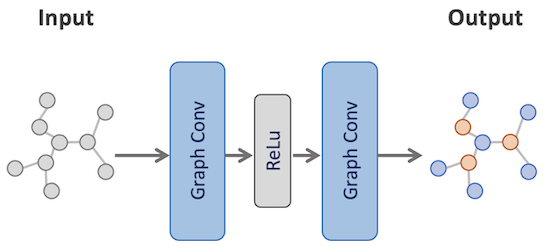

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16) # First GCN layer
        self.conv2 = GCNConv(16, dataset.num_classes)       # Second GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index # Extract features and edge index from data
        x = self.conv1(x, edge_index)           # Apply first GCN layer
        x = F.relu(x)                           # Apply ReLU activation function
        x = self.conv2(x, edge_index)           # Apply second GCN layer
        return x                                # Return the logits for each class

    def predict(self, data, indices):
        self.eval()                             # Set the model to evaluation mode
        with torch.no_grad():
            out = self.forward(data)
            out = F.softmax(out, dim=1)         # Apply softmax to get probabilities
            return out[indices]                 # Return the predictions for the specified indices

In [ ]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=100):
    train_losses = []   # List to store training losses
    val_accuracies = [] # List to store validation accuracies

    for epoch in range(1, n_epochs + 1):
        model.train()         # Set the model to training mode
        optimizer.zero_grad() # Clear previous gradients
        out = model(graph)    # Forward pass
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask]) # Compute loss
        loss.backward()       # Backpropagation
        optimizer.step()      # Update model parameters

        train_losses.append(loss.item()) # Record training loss

        acc = eval_node_classifier(model, graph, graph.val_mask) # Evaluate on validation set
        val_accuracies.append(acc) # Record validation accuracy

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    return model, train_losses, val_accuracies


def eval_node_classifier(model, graph, mask):
    model.eval()          # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient computation
        out = model(graph)
        pred = out.argmax(dim=1) # Get predictions by finding the max logits
        correct = (pred[mask] == graph.y[mask]).sum() # Count correct predictions
        acc = int(correct) / int(mask.sum()) # Calculate accuracy
    return acc


def generate_classification_report(model, graph, mask):
    model.eval()          # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient computation
        out = model(graph)
        pred = out.argmax(dim=1) # Get predictions by finding the max logits

        # Generate classification report
        true_labels = graph.y[mask].cpu().numpy()
        pred_labels = pred[mask].cpu().numpy()
        report = classification_report(true_labels, pred_labels, output_dict=False)
        print(report)

    return report

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Check if GPU is available

**Model Instantiation:** <font color='lightgreen'>[Control Experiment] GCN Without Class Weights</font>

In [ ]:
# Instantiate the model without class weights
model_without_weights = GCN().to(device)
optimizer = torch.optim.Adam(model_without_weights.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

**Model Instantiation:** <font color='lightpink'>[Experiment] GCN With Class Weights</font>

In [ ]:
# Implement class weight modification
class_counts = torch.bincount(graph.y[graph.train_mask])
class_weights = class_counts.float().max() / class_counts.float()  # Inverse frequency
class_weights = class_weights.to(graph.y.device)  # Move to the same device as data

# Instantiate the model with class weights
model_with_weights = GCN().to(device)
optimizer_with_weights = torch.optim.Adam(model_with_weights.parameters(), lr=0.01, weight_decay=5e-4)
criterion_with_weights = torch.nn.CrossEntropyLoss(weight=class_weights)

**Train the models >>>**

<font color='lightgreen'>Control Experiment: GCN Without Class Weights</font>

In [ ]:
# Train model without class weights
model_without_weights, train_losses, val_accuracies = train_node_classifier(
    model_without_weights, graph, optimizer, criterion)

Epoch: 010, Train Loss: 1.063, Val Acc: 0.631
Epoch: 020, Train Loss: 0.487, Val Acc: 0.889
Epoch: 030, Train Loss: 0.272, Val Acc: 0.897
Epoch: 040, Train Loss: 0.200, Val Acc: 0.900
Epoch: 050, Train Loss: 0.167, Val Acc: 0.904
Epoch: 060, Train Loss: 0.150, Val Acc: 0.900
Epoch: 070, Train Loss: 0.139, Val Acc: 0.900
Epoch: 080, Train Loss: 0.130, Val Acc: 0.904
Epoch: 090, Train Loss: 0.122, Val Acc: 0.897
Epoch: 100, Train Loss: 0.114, Val Acc: 0.893


**Train the models >>>**

<font color='lightpink'>Experiment: GCN With Class Weights</font>

In [ ]:
# Train model with class weights
model_with_weights, train_losses_with_weights, val_accuracies_with_weights = train_node_classifier(
    model_with_weights, graph, optimizer_with_weights, criterion_with_weights)

Epoch: 010, Train Loss: 0.964, Val Acc: 0.812
Epoch: 020, Train Loss: 0.391, Val Acc: 0.867
Epoch: 030, Train Loss: 0.238, Val Acc: 0.878
Epoch: 040, Train Loss: 0.184, Val Acc: 0.875
Epoch: 050, Train Loss: 0.159, Val Acc: 0.871
Epoch: 060, Train Loss: 0.146, Val Acc: 0.875
Epoch: 070, Train Loss: 0.137, Val Acc: 0.871
Epoch: 080, Train Loss: 0.128, Val Acc: 0.871
Epoch: 090, Train Loss: 0.120, Val Acc: 0.871
Epoch: 100, Train Loss: 0.114, Val Acc: 0.867


**Evaluate and Compare the Models**

In [ ]:
test_accuracy_without_weights = eval_node_classifier(model_without_weights, graph, graph.test_mask)
test_accuracy_with_weights = eval_node_classifier(model_with_weights, graph, graph.test_mask)

print(f"Test Accuracy without weights: {test_accuracy_without_weights:.3f}")
print(f"Test Accuracy with weights: {test_accuracy_with_weights:.3f}")

Test Accuracy without weights: 0.889
Test Accuracy with weights: 0.871


**Generate Classification Report to Check the Metrics**

<font color='lightgreen'>Control Experiment: GCN Without Class Weights</font>

In [ ]:
GCN_without_weights_report = generate_classification_report(model_without_weights, graph, graph.test_mask)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.88      0.82      0.85        28
           2       0.92      0.98      0.95        47
           3       0.92      0.87      0.90        79
           4       0.86      0.88      0.87        42
           5       0.76      0.95      0.84        20
           6       0.94      0.79      0.86        19

    accuracy                           0.89       271
   macro avg       0.88      0.88      0.88       271
weighted avg       0.89      0.89      0.89       271



<font color='lightpink'>Experiment: GCN With Class Weights</font>

In [ ]:
GCN_with_weights_report = generate_classification_report(model_with_weights, graph, graph.test_mask)

              precision    recall  f1-score   support

           0       0.86      0.89      0.88        36
           1       0.81      0.79      0.80        28
           2       0.92      0.98      0.95        47
           3       0.93      0.81      0.86        79
           4       0.84      0.90      0.87        42
           5       0.76      0.95      0.84        20
           6       0.83      0.79      0.81        19

    accuracy                           0.87       271
   macro avg       0.85      0.87      0.86       271
weighted avg       0.87      0.87      0.87       271



**Results Visualization**

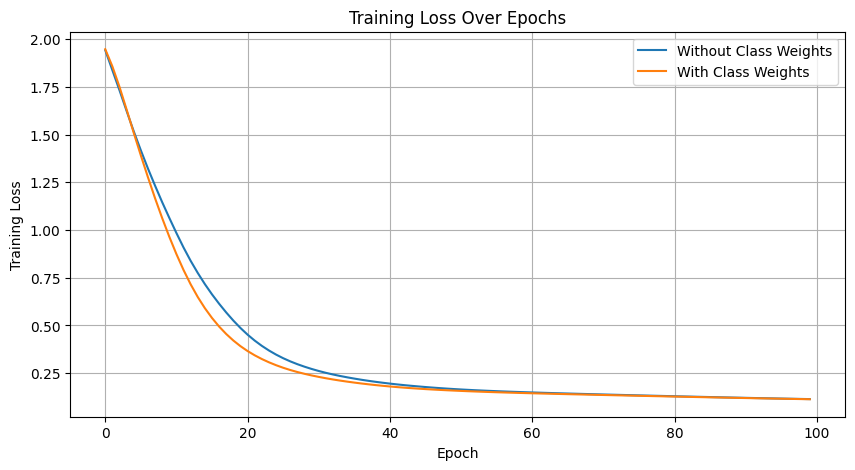

In [ ]:
# Creating plot: 'Training Loss Over Epochs'
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Without Class Weights')
plt.plot(train_losses_with_weights, label='With Class Weights')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

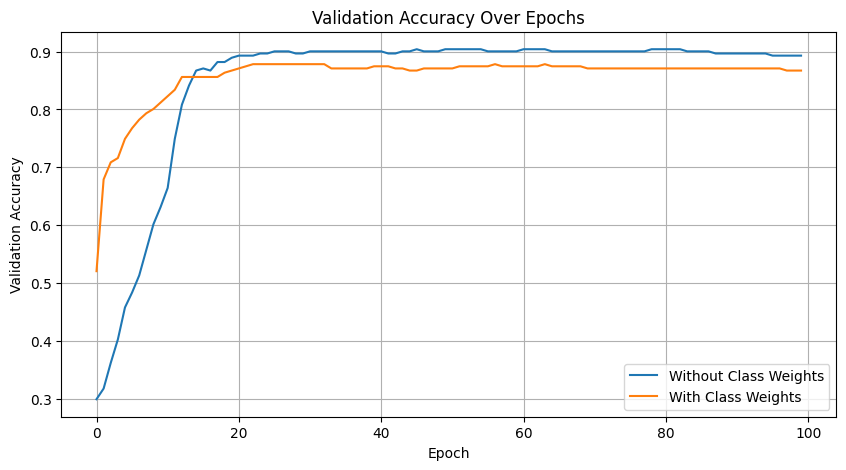

In [ ]:
# Creating plot: 'Validation Accuracy Over Epochs'
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Without Class Weights')
plt.plot(val_accuracies_with_weights, label='With Class Weights')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Evaluate and interpret how well the GCN model performs on the test data, specifically looking at the probabilistic outputs and how they compare to the true labels.**

In [ ]:
class_idx = {
    "Case_Based": 0,
    "Genetic_Algorithms": 1,
    "Neural_Networks": 2,
    "Probabilistic_Methods": 3,
    "Reinforcement_Learning": 4,
    "Rule_Learning": 5,
    "Theory": 6
}
mapping = {v: k for (k, v) in class_idx.items()}

test_indices = graph.test_mask.nonzero(as_tuple=True)[0]
test_labels = graph.y[test_indices]

test_probs = model_without_weights.predict(graph, test_indices)

print("GCN Model Without Class Weight")
print("---" * 20)

for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Example {i+1}: {mapping[label.item()]}")
    for j, c in zip(probs, class_idx.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---" * 20)

GCN Model Without Class Weight
------------------------------------------------------------
Example 1: Reinforcement_Learning
	Probability of Case_Based               =   0.254%
	Probability of Genetic_Algorithms       =   0.007%
	Probability of Neural_Networks          =   0.001%
	Probability of Probabilistic_Methods    =   8.215%
	Probability of Reinforcement_Learning   =  91.520%
	Probability of Rule_Learning            =   0.000%
	Probability of Theory                   =   0.002%
------------------------------------------------------------
Example 2: Probabilistic_Methods
	Probability of Case_Based               =   0.283%
	Probability of Genetic_Algorithms       =   0.294%
	Probability of Neural_Networks          =   0.348%
	Probability of Probabilistic_Methods    =  98.388%
	Probability of Reinforcement_Learning   =   0.534%
	Probability of Rule_Learning            =   0.078%
	Probability of Theory                   =   0.074%
----------------------------------------------------

In [ ]:
mapping = {v: k for (k, v) in class_idx.items()}

test_indices = graph.test_mask.nonzero(as_tuple=True)[0]
test_labels = graph.y[test_indices]

test_probs = model_with_weights.predict(graph, test_indices)

print("GCN With Class Weight")
print("---" * 20)

for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Example {i+1}: {mapping[label.item()]}")
    for j, c in zip(probs, class_idx.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---" * 20)

GCN With Class Weight
------------------------------------------------------------
Example 1: Reinforcement_Learning
	Probability of Case_Based               =   0.202%
	Probability of Genetic_Algorithms       =   0.001%
	Probability of Neural_Networks          =   0.003%
	Probability of Probabilistic_Methods    =   5.320%
	Probability of Reinforcement_Learning   =  94.457%
	Probability of Rule_Learning            =   0.001%
	Probability of Theory                   =   0.016%
------------------------------------------------------------
Example 2: Probabilistic_Methods
	Probability of Case_Based               =   0.715%
	Probability of Genetic_Algorithms       =   1.258%
	Probability of Neural_Networks          =   0.443%
	Probability of Probabilistic_Methods    =  96.545%
	Probability of Reinforcement_Learning   =   0.747%
	Probability of Rule_Learning            =   0.242%
	Probability of Theory                   =   0.051%
------------------------------------------------------------


In [ ]:
def convert_to_networkx(graph, n_sample=None):
    """
    Convert a PyTorch Geometric graph to a NetworkX graph, optionally sampling a subset of nodes.

    Args:
        graph: A PyTorch Geometric Data object.
        n_sample: Optional; the number of nodes to sample from the graph.

    Returns:
        A tuple of (g, y) where 'g' is the NetworkX graph and 'y' are the labels for the nodes in 'g'.
    """
    g = to_networkx(graph, node_attrs=["x"])  # Convert to NetworkX graph, including node features
    y = graph.y.numpy()  # Convert labels to a numpy array

    # If sampling is specified, sample 'n_sample' nodes randomly
    if n_sample is not None:
        sampled_nodes = random.sample(list(g.nodes), n_sample)  # Ensure conversion to list for sampling
        g = g.subgraph(sampled_nodes).copy()  # Create a subgraph based on sampled nodes and ensure it's a deep copy
        y = y[sampled_nodes]  # Subset the labels to correspond to the sampled nodes

    return g, y

def plot_graph(g, y):
    """
    Plot a NetworkX graph with nodes colored based on their labels.

    Args:
        g: A NetworkX graph.
        y: Labels for the nodes, used for coloring.
    """
    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y, cmap=plt.get_cmap('viridis'))  # Use 'viridis' colormap
    plt.show()

def visualize_classification_result(model, graph):
    """
    Visualize the classification results of a model on a test set within the graph.
    Correct predictions are marked yellow, incorrect ones are purple.

    Args:
        model: A trained PyTorch Geometric model.
        graph: A PyTorch Geometric Data object.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        pred = model(graph).argmax(dim=1)  # Get the model predictions
    corrects = (pred[graph.test_mask] == graph.y[graph.test_mask]).numpy().astype(int)  # Determine correctness
    test_index = np.where(graph.test_mask.numpy())[0]  # Get indices of test nodes

    g, _ = convert_to_networkx(graph)  # Convert the whole graph to NetworkX
    g_test = g.subgraph(test_index).copy()  # Create a subgraph of only test nodes

    print("Yellow node: correct \nPurple node: wrong")
    plot_graph(g_test, corrects)  # Plot test nodes with correctness indicated

Yellow node: correct 
Purple node: wrong


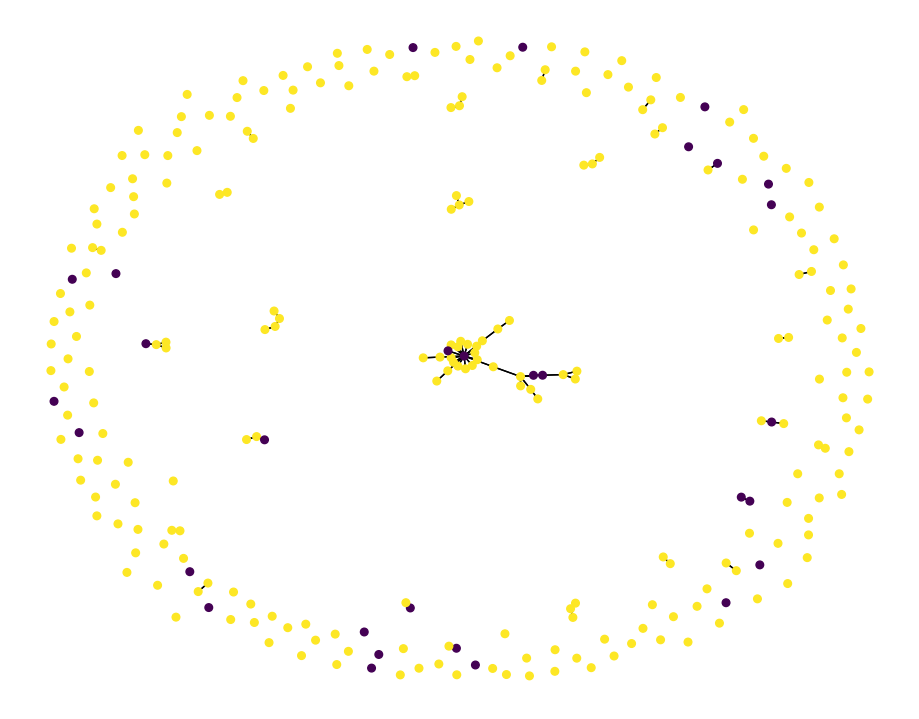

In [ ]:
visualize_classification_result(model_without_weights, graph)

Yellow node: correct 
Purple node: wrong


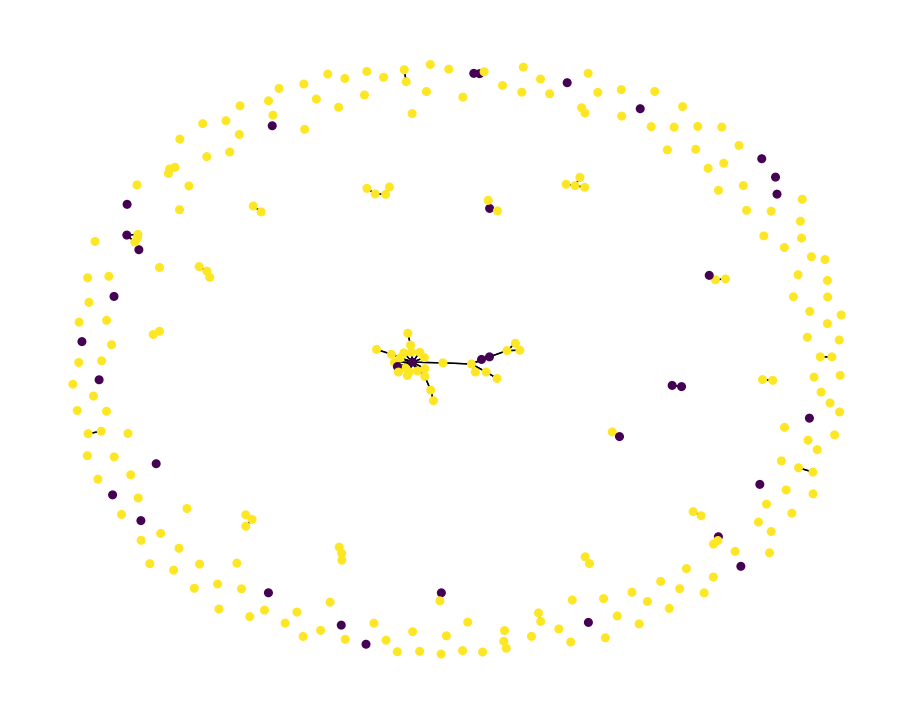

In [ ]:
visualize_classification_result(model_with_weights, graph)

## 4.0 Graph Attention Networks (GAT)


![GAT](https://miro.medium.com/v2/resize:fit:1342/format:webp/1*dhvS-MmVUuG0UBk6TCoukA.png)

GAT offers a novel approach to neural networks for graph-structured data. Unlike traditional graph convolutional methods, GATs utilize masked self-attention layers to overcome their limitations. By stacking these layers, GATs allow nodes to focus on ("attend to") the features of their neighbors in a nuanced way. This enables the network to assign varying importance to different neighbors within a node's community, leading to potentially more accurate learning.

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def predict(self, data, indices):
        self.eval()
        with torch.no_grad():
            out = self.forward(data)
            out = F.softmax(out, dim=1)
            return out[indices]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Check if GPU is available

**Model Instantiation:** <font color='cyan'>[Control Experitment] GAT Without Class Weights</font>

In [ ]:
input_dim = dataset.num_node_features
hidden_dim = 8
output_dim = dataset.num_classes
heads = 8

# Instantiate the model without weights
model_without_weights = GAT(input_dim, hidden_dim, output_dim, heads=heads).to(device)
optimizer = torch.optim.Adam(model_without_weights.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

**Model Instantiation:** <font color='lightyellow'> [Experitment] GAT With Class Weights</font>

In [ ]:
class_counts = torch.bincount(graph.y[graph.train_mask])
class_weights = class_counts.float().max() / class_counts.float()  # Inverse frequency
class_weights = class_weights.to(graph.y.device)  # Move to the same device as data

# Instantiate the model with weights
model_with_weights = GAT(input_dim, hidden_dim, output_dim, heads=heads).to(device)
optimizer_with_weights = torch.optim.Adam(model_with_weights.parameters(), lr=0.01, weight_decay=5e-4)
criterion_with_weights = torch.nn.CrossEntropyLoss(weight=class_weights)

**Model Training >>>** <font color='cyan'>Controlled Experitment: GAT Without Class Weights</font>

In [ ]:
# Train model without class weights
model_without_weights, train_losses, val_accuracies = train_node_classifier(
    model_without_weights, graph, optimizer, criterion)

Epoch: 010, Train Loss: 0.822, Val Acc: 0.867
Epoch: 020, Train Loss: 0.637, Val Acc: 0.897
Epoch: 030, Train Loss: 0.598, Val Acc: 0.893
Epoch: 040, Train Loss: 0.562, Val Acc: 0.897
Epoch: 050, Train Loss: 0.530, Val Acc: 0.889
Epoch: 060, Train Loss: 0.543, Val Acc: 0.889
Epoch: 070, Train Loss: 0.543, Val Acc: 0.897
Epoch: 080, Train Loss: 0.524, Val Acc: 0.900
Epoch: 090, Train Loss: 0.555, Val Acc: 0.893
Epoch: 100, Train Loss: 0.552, Val Acc: 0.878


**Model Training >>>** <font color='lightyellow'> Experitment: GAT With Class Weights</font>

In [ ]:
# Train model with class weights
model_with_weights, train_losses_with_weights, val_accuracies_with_weights = train_node_classifier(
    model_with_weights, graph, optimizer_with_weights, criterion_with_weights)

Epoch: 010, Train Loss: 0.805, Val Acc: 0.849
Epoch: 020, Train Loss: 0.639, Val Acc: 0.886
Epoch: 030, Train Loss: 0.612, Val Acc: 0.886
Epoch: 040, Train Loss: 0.581, Val Acc: 0.878
Epoch: 050, Train Loss: 0.537, Val Acc: 0.875
Epoch: 060, Train Loss: 0.543, Val Acc: 0.882
Epoch: 070, Train Loss: 0.554, Val Acc: 0.878
Epoch: 080, Train Loss: 0.538, Val Acc: 0.867
Epoch: 090, Train Loss: 0.537, Val Acc: 0.867
Epoch: 100, Train Loss: 0.528, Val Acc: 0.875


**Evaluate and Compare the Models**

In [ ]:
test_accuracy_without_weights = eval_node_classifier(model_without_weights, graph, graph.test_mask)
test_accuracy_with_weights = eval_node_classifier(model_with_weights, graph, graph.test_mask)

print(f"Test Accuracy without weights: {test_accuracy_without_weights:.3f}")
print(f"Test Accuracy with weights: {test_accuracy_with_weights:.3f}")

Test Accuracy without weights: 0.886
Test Accuracy with weights: 0.893


**Generate Classification Report to Check the Metrics**

<font color='cyan'>Control Experitment: GAT Without Class Weights</font>

In [ ]:
GAT_without_weights_report = generate_classification_report(model_without_weights, graph, graph.test_mask)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.88      0.75      0.81        28
           2       0.92      1.00      0.96        47
           3       0.92      0.85      0.88        79
           4       0.85      0.95      0.90        42
           5       0.78      0.90      0.84        20
           6       0.88      0.79      0.83        19

    accuracy                           0.89       271
   macro avg       0.87      0.88      0.87       271
weighted avg       0.89      0.89      0.88       271



<font color='lightyellow'> Experitment: GAT With Class Weights</font>

In [ ]:
GAT_with_weights_report = generate_classification_report(model_with_weights, graph, graph.test_mask)

              precision    recall  f1-score   support

           0       0.94      0.89      0.91        36
           1       0.82      0.82      0.82        28
           2       0.94      0.96      0.95        47
           3       0.93      0.84      0.88        79
           4       0.87      0.95      0.91        42
           5       0.83      0.95      0.88        20
           6       0.81      0.89      0.85        19

    accuracy                           0.89       271
   macro avg       0.88      0.90      0.89       271
weighted avg       0.90      0.89      0.89       271



**Results Visualization**

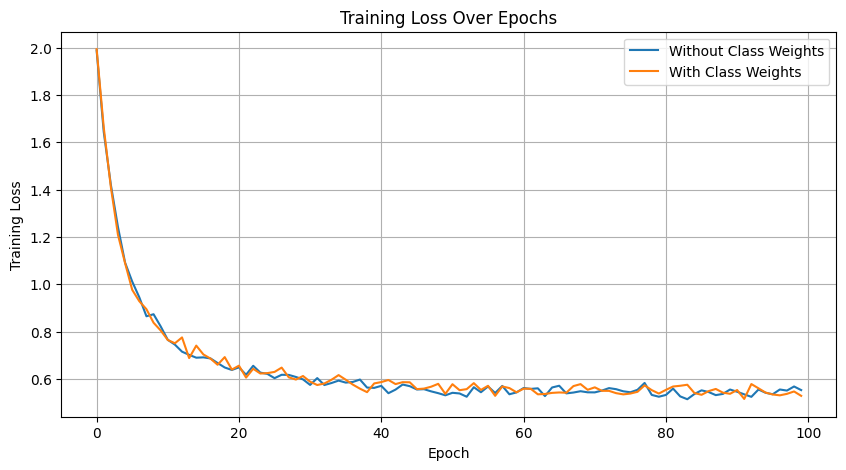

In [ ]:
# Creating plot: 'Training Loss Over Epochs'
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Without Class Weights')
plt.plot(train_losses_with_weights, label='With Class Weights')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

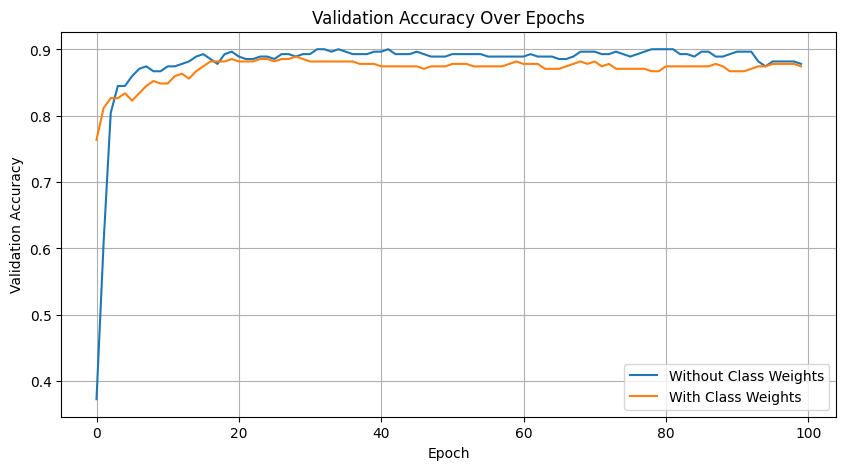

In [ ]:
# Creating plot: 'Validation Accuracy Over Epochs'
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Without Class Weights')
plt.plot(val_accuracies_with_weights, label='With Class Weights')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Evaluate and interpret how well the GAT model performs on the test data, specifically looking at the probabilistic outputs and how they compare to the true labels.**

In [ ]:
class_idx = {
    "Case_Based": 0,
    "Genetic_Algorithms": 1,
    "Neural_Networks": 2,
    "Probabilistic_Methods": 3,
    "Reinforcement_Learning": 4,
    "Rule_Learning": 5,
    "Theory": 6
}
mapping = {v: k for (k, v) in class_idx.items()}

test_indices = graph.test_mask.nonzero(as_tuple=True)[0]
test_labels = graph.y[test_indices]

test_probs = model_without_weights.predict(graph, test_indices)

print("GAT Model Without Class Weight")
print("---" * 20)

for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Example {i+1}: {mapping[label.item()]}")
    for j, c in zip(probs, class_idx.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---" * 20)

GAT Model Without Class Weight
------------------------------------------------------------
Example 1: Reinforcement_Learning
	Probability of Case_Based               =   0.834%
	Probability of Genetic_Algorithms       =   0.044%
	Probability of Neural_Networks          =   0.248%
	Probability of Probabilistic_Methods    =  17.596%
	Probability of Reinforcement_Learning   =  81.249%
	Probability of Rule_Learning            =   0.020%
	Probability of Theory                   =   0.010%
------------------------------------------------------------
Example 2: Probabilistic_Methods
	Probability of Case_Based               =   0.147%
	Probability of Genetic_Algorithms       =   0.465%
	Probability of Neural_Networks          =   0.054%
	Probability of Probabilistic_Methods    =  99.195%
	Probability of Reinforcement_Learning   =   0.087%
	Probability of Rule_Learning            =   0.023%
	Probability of Theory                   =   0.029%
----------------------------------------------------

In [ ]:
mapping = {v: k for (k, v) in class_idx.items()}

test_indices = graph.test_mask.nonzero(as_tuple=True)[0]
test_labels = graph.y[test_indices]

test_probs = model_with_weights.predict(graph, test_indices)

print("GAT With Class Weight")
print("---" * 20)

for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Example {i+1}: {mapping[label.item()]}")
    for j, c in zip(probs, class_idx.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---" * 20)

GAT With Class Weight
------------------------------------------------------------
Example 1: Reinforcement_Learning
	Probability of Case_Based               =   0.568%
	Probability of Genetic_Algorithms       =   0.155%
	Probability of Neural_Networks          =   0.026%
	Probability of Probabilistic_Methods    =   5.314%
	Probability of Reinforcement_Learning   =  93.749%
	Probability of Rule_Learning            =   0.160%
	Probability of Theory                   =   0.028%
------------------------------------------------------------
Example 2: Probabilistic_Methods
	Probability of Case_Based               =   0.289%
	Probability of Genetic_Algorithms       =   2.056%
	Probability of Neural_Networks          =   0.057%
	Probability of Probabilistic_Methods    =  97.117%
	Probability of Reinforcement_Learning   =   0.303%
	Probability of Rule_Learning            =   0.094%
	Probability of Theory                   =   0.084%
------------------------------------------------------------


Yellow node: correct 
Purple node: wrong


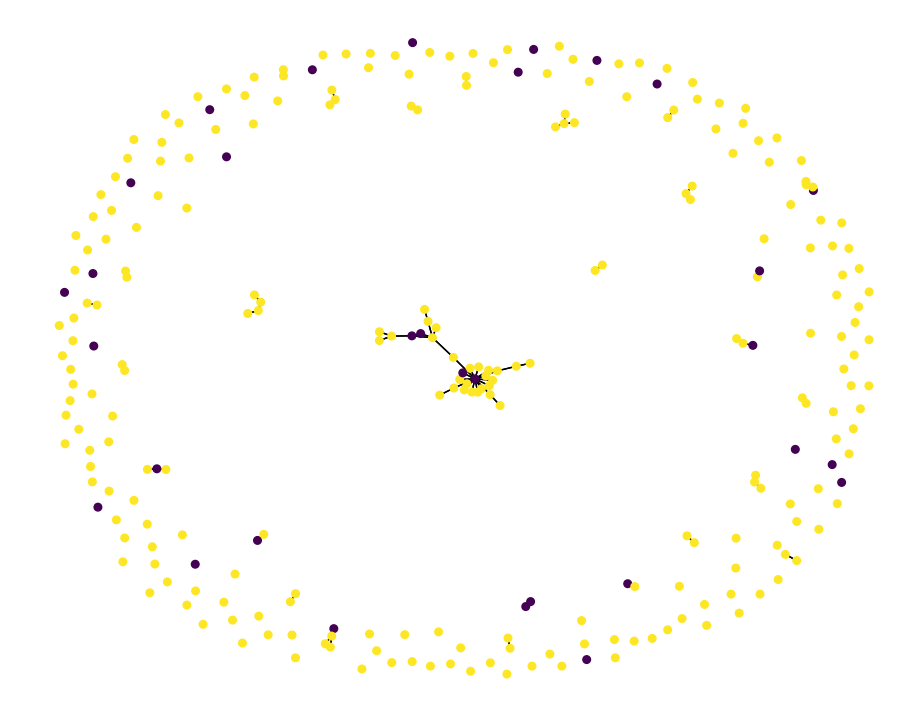

In [ ]:
visualize_classification_result(model_without_weights, graph)

Yellow node: correct 
Purple node: wrong


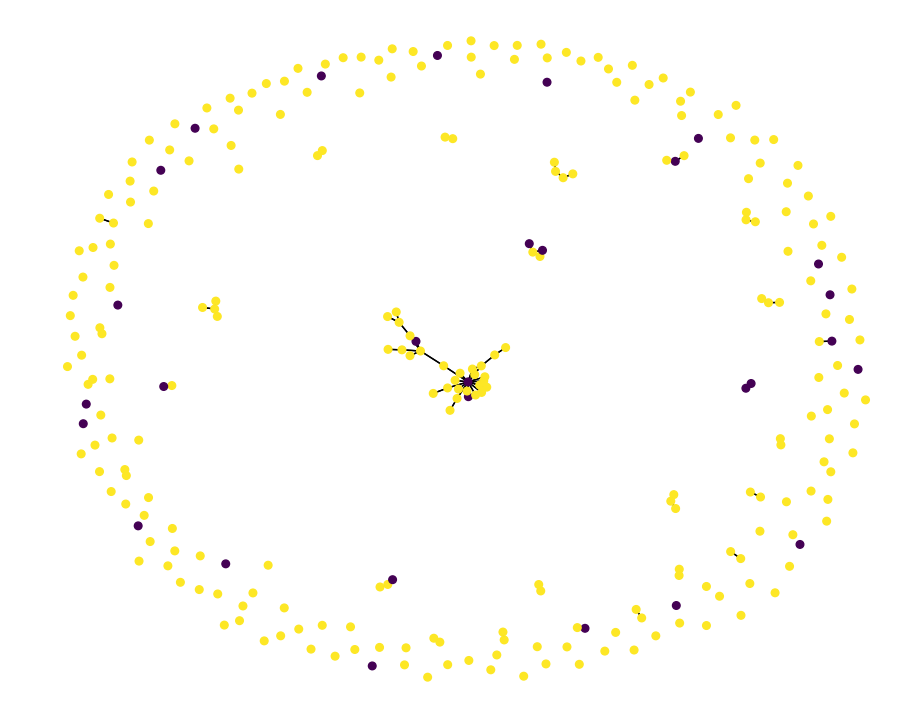

In [ ]:
visualize_classification_result(model_with_weights, graph)